In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
import imgaug as ia

%config InlineBackend.fugure_format = 'retina'

%load_ext autoreload

/home/semyon/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


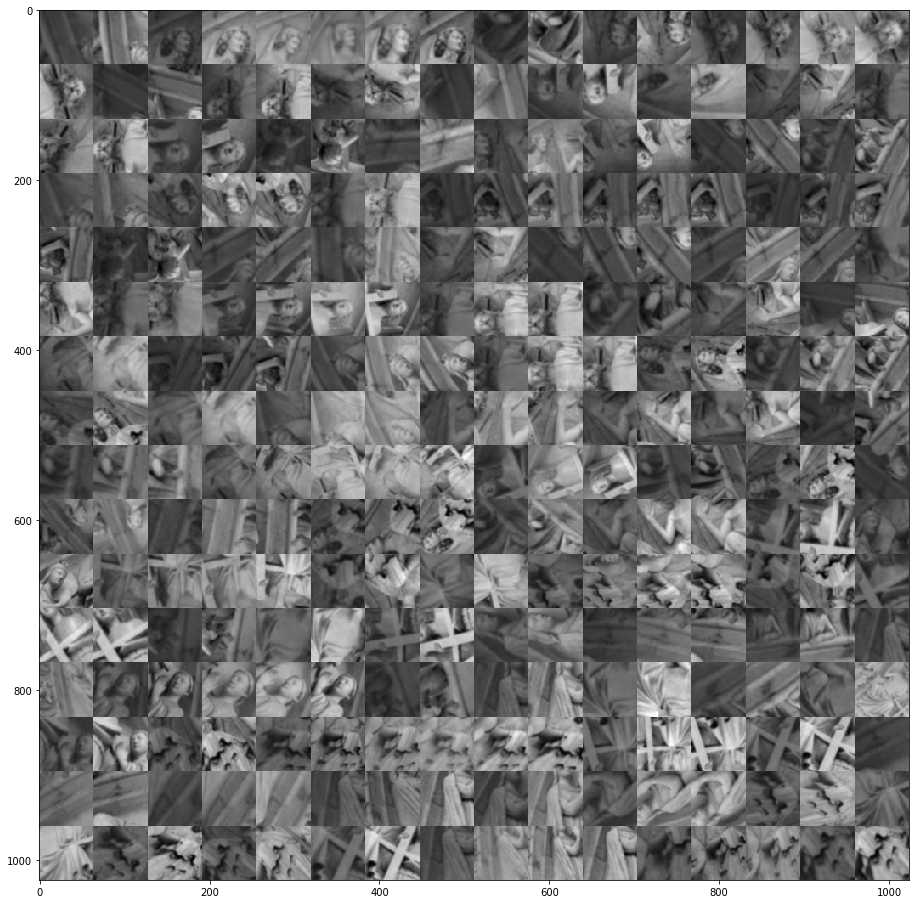

In [2]:
%autoreload
from utils import read_bitmap, read_patch, cut_patch_from_bitmap

DATA_ROOT = '../data'
NOTREDAME = f'{DATA_ROOT}/notredame'
LIBERTY = f'{DATA_ROOT}/liberty'

bmp = read_bitmap(NOTREDAME, 0)
plt.figure(figsize=(16, 16))
plt.imshow(bmp, shape=(16, 16), cmap='gray');

In [3]:
cut_patch_from_bitmap(bmp, 12).shape

(64, 64)

In [4]:
info_file = pd.read_csv(f'{NOTREDAME}/info.txt', delimiter=' ', names=['patch_id', 'unused'])
info_file[10:16]

,patch_id,unused
10,3,0
11,3,0
12,4,0
13,4,0
14,4,0
15,4,0


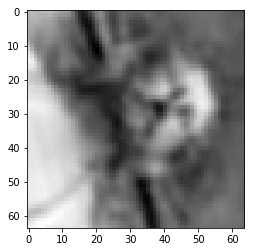

In [5]:
plt.imshow(read_patch(NOTREDAME, 12), cmap='gray');

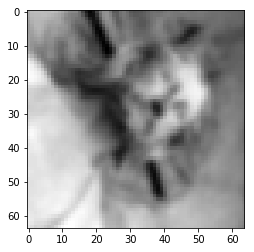

In [6]:
plt.imshow(read_patch(NOTREDAME, 13), cmap='gray');

In [7]:
match_file = pd.read_csv(f'{NOTREDAME}/m50_50000_50000_0.txt', delimiter=' ', 
    names=['patchID1', '3DpointID1', 'unused1', 'patchID2','3DpointID2', 'unused2', 'unused3'])
match_file.head()

,patchID1,3DpointID1,unused1,patchID2,3DpointID2,unused2,unused3
0,130856,39583,0,217903,67429,0,0
1,451659,142159,0,451660,142159,0,0
2,33399,10806,0,397913,125276,0,0
3,195398,60480,0,255973,77894,0,0
4,38293,12062,0,69767,20959,0,0


In [8]:
match_file = match_file.sample(frac=1)
match_file.head()

,patchID1,3DpointID1,unused1,patchID2,3DpointID2,unused2,unused3
30148,292772,88318,0,292775,88318,0,0
11719,211066,65549,0,331278,102519,0,0
23915,133393,40580,0,143105,43690,0,0
39776,54336,16636,0,465000,146494,0,0
41536,15117,4399,0,131858,39999,0,0


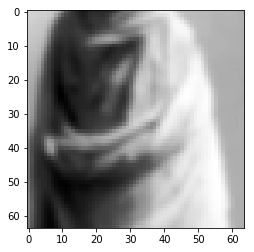

In [9]:
patch = read_patch(LIBERTY, 13)
plt.imshow(patch, cmap='gray');

In [10]:
patch

array([[209, 208, 208, ..., 181, 179, 178],
       [207, 207, 206, ..., 182, 180, 179],
       [206, 205, 204, ..., 182, 181, 180],
       ...,
       [138, 108,  84, ..., 180, 179, 179],
       [136, 106,  84, ..., 181, 179, 179],
       [134, 104,  82, ..., 181, 179, 179]], dtype=uint8)

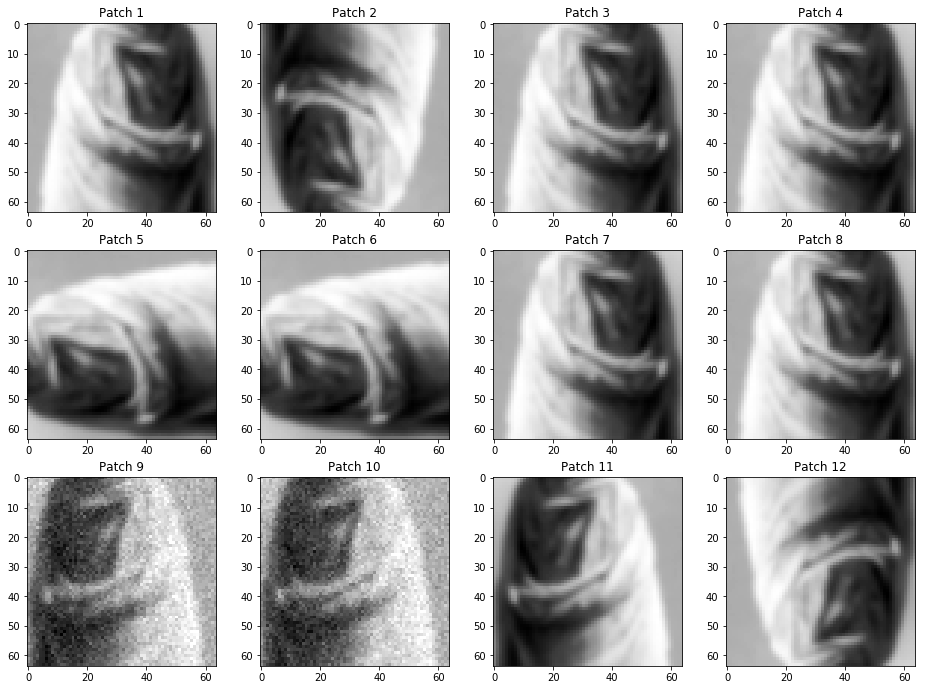

In [11]:
from imgaug import augmenters as iaa
from utils import show_images

aug = iaa.OneOf([
    iaa.Fliplr(p=1.0),
    iaa.Flipud(p=1.0),
    iaa.Affine(rotate=(90)),
    iaa.Affine(rotate=(180)),
    iaa.Affine(rotate=(270)),
    iaa.Noop(),
    iaa.AdditiveGaussianNoise(scale=0.05 * 255)
])

patches = [patch] * 12
augmented = aug.augment_images(patches)

show_images(augmented, 4)

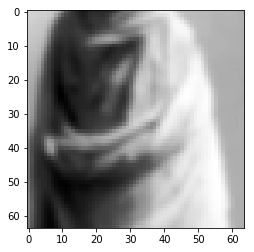

In [12]:
plt.imshow(patch / 255, cmap='gray');

In [13]:
import os

TEXTS = f'{DATA_ROOT}/texts'
image_files = os.listdir(TEXTS)
print(image_files[:10], len(image_files))

['800.png', '632.png', '43.png', '216.png', '621.png', '311.png', '570.png', '432.png', '924.png', '749.png'] 973


In [14]:
from imgaug import augmenters as iaa

sift = cv2.xfeatures2d.SIFT_create(100)

In [15]:
%autoreload
from utils import read_image

IMAGE_FILE = f'{TEXTS}/666.png'

img = read_image(IMAGE_FILE)
sift_kps = sift.detect(img)

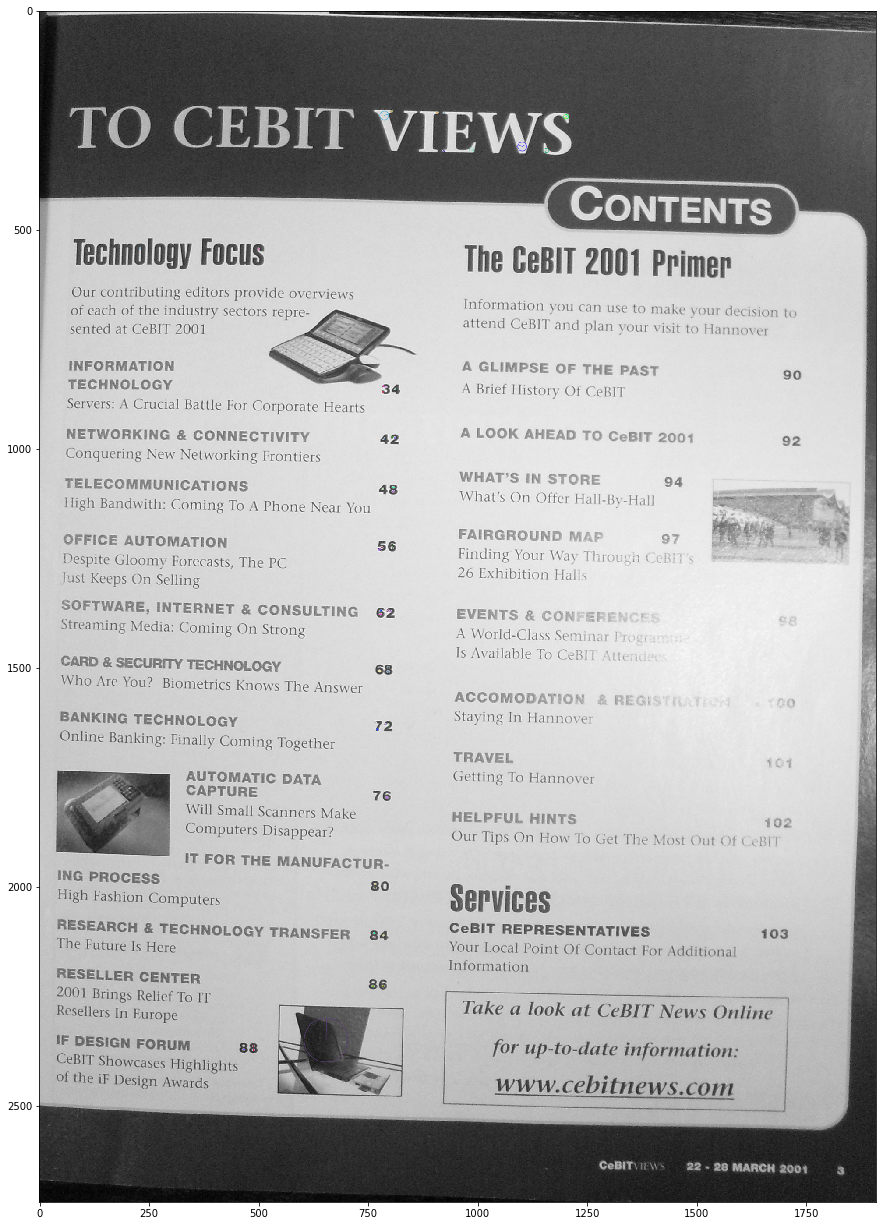

(2719, 1911)


In [16]:
img_with_kps = cv2.drawKeypoints(img, sift_kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(15, 25))
plt.imshow(img_with_kps);
plt.show()

print(img.shape)

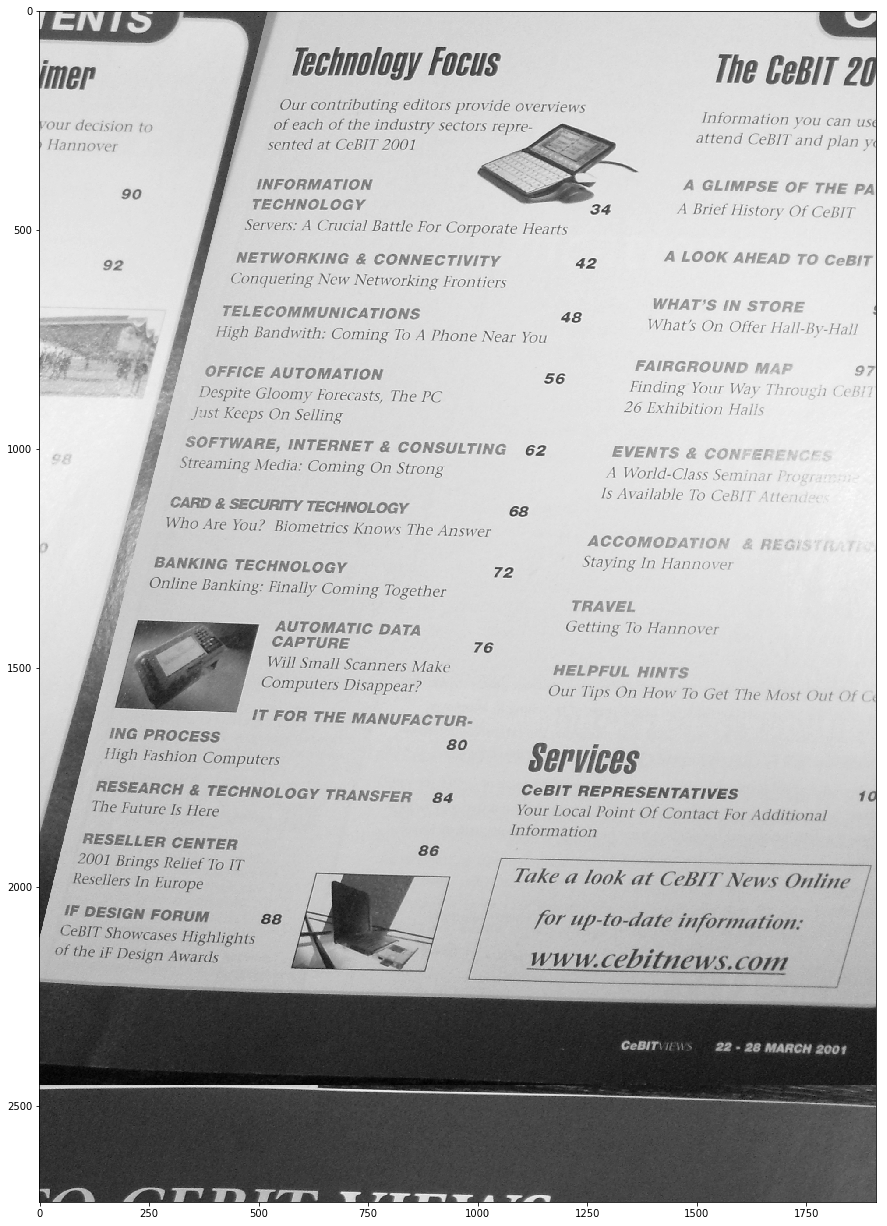

In [17]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

aug = iaa.Sequential([
    #sometimes(iaa.Crop(percent=(0, 0.1))),
    sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        shear=(-16, 16),
        order=[0, 1],
        cval=(0, 255),
        mode='wrap'
    )),
    
    iaa.SomeOf((0, 3), [
        iaa.OneOf([
            iaa.GaussianBlur((0, 3.0)),
            iaa.AverageBlur(k=(2, 7)),
            iaa.MedianBlur(k=(3, 11)),
        ]),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255)),
        iaa.Multiply((0.5, 1.5)),
        iaa.ContrastNormalization((0.5, 2.0)),
        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
    ], random_order=True)
], random_order=True)

aug_img = aug.augment_images([img])[0]
kps = ia.KeypointsOnImage([ia.Keypoint(x=int(kp.pt[0]), y=int(kp.pt[1])) for kp in sift_kps], shape=img.shape)
aug_kps = aug.augment_keypoints([kps])[0]

plt.figure(figsize=(15, 25))
plt.imshow(aug_img, cmap='gray');
plt.show()

3.9705708026885986 (64, 64)


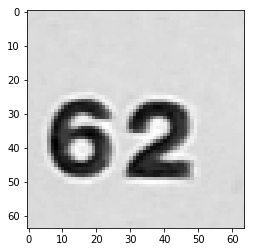

In [18]:
%autoreload
from utils import read_keypoint_patch

i = np.random.randint(100)
#i = np.argmax([k.size for k in sift_kps])

kp = sift_kps[i]
patch = read_keypoint_patch(IMAGE_FILE, kp.pt[0], kp.pt[1], kp.size)

plt.imshow(patch, cmap='gray');
print(kp.size, patch.shape)

In [19]:
!rm -r {DATA_ROOT}/texts_heavy_aug

rm: cannot remove '../data/texts_heavy_aug': No such file or directory


In [20]:
%autoreload
from utils import create_aug_dataset

aug = iaa.AdditiveGaussianNoise(scale=0.15 * 255)

src_dataset = os.path.realpath(TEXTS)
dest_dataset = os.path.realpath(f'{DATA_ROOT}/texts_heavy_aug')

error_files = create_aug_dataset(src_dataset, dest_dataset, aug)

100%|██████████| 973/973 [35:06<00:00,  2.16s/it]


In [22]:
error_files

['/home/semyon/abbyy-diploma/descriptor/data/texts/145.png',
 '/home/semyon/abbyy-diploma/descriptor/data/texts/691.png',
 '/home/semyon/abbyy-diploma/descriptor/data/texts/926.png']